# Dropout改为Activation Function ReLu

## 载入套件

In [11]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 设定参数

In [12]:
PATH_DATASETS = "" # 预设路径
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步骤1：载入 MNIST 手写阿拉伯数字资料

In [13]:
# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下载测试资料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步骤2：资料清理，此步骤无需进行

## 步骤3：特征工程，此步骤无需进行

## 步骤4：资料分割，此步骤无需进行，载入MNIST资料时，已经切割好了

## 步骤5：建立模型结构

In [14]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 512), 
    torch.nn.ReLU(), 
    torch.nn.Linear(512, 10), 
).to(device)

## 步骤6：结合训练资料及模型，进行模型训练

In [15]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 设定优化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.307127
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 2.129434
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.954336
Epoch 1: [18000 / 60000] (30 %)  Loss: 1.749348
Epoch 1: [24000 / 60000] (40 %)  Loss: 1.495344
Epoch 1: [30000 / 60000] (50 %)  Loss: 1.344144
Epoch 1: [36000 / 60000] (60 %)  Loss: 1.080870
Epoch 1: [42000 / 60000] (70 %)  Loss: 1.010563
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.739745
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.753174
Epoch 2: [    0 / 60000] (0 %)  Loss: 0.693038
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.543802
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.633745
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.549982
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.566139
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.621294
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.504025
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.589850
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.406506
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.459515
Epoch 3: [    0 / 60000] (0 %)  Loss: 0.44

## 对训练过程的损失绘图

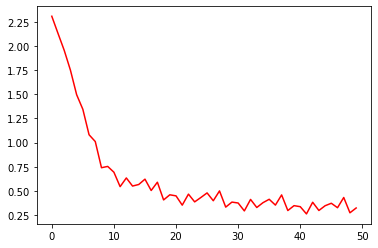

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步骤7：评分(Score Model)

In [17]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 预测
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正确笔数
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均损失
test_loss /= len(test_loader.dataset)
# 显示测试结果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均损失: {test_loss:.4f}, 准确率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均损失: 0.0003, 准确率: 9109/10000 (91%)



## 实际比对测试资料的前20笔

In [18]:
# 实际预测 20 笔资料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比对
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


## 步骤8：评估，暂不进行

## 步骤9：模型布署

## 步骤10：新资料预测

In [20]:
# 使用小画家，绘制 0~9，实际测试看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 读取影像并转为单色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 缩为 (28, 28) 大小的影像
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) #/ 255.0

    # 反转颜色，颜色0为白色，与 RGB 色码不同，它的 0 为黑色
    X1 = torch.FloatTensor(1-X1).to(device)

    # 预测
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 6
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 0
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 1
actual/prediction: 8 8
actual/prediction: 9 1
